# WA5FRF Chirp Experiment Analysis Script
Stephen A. Cerwin WA5FRF and Nathaniel A. Frissell W2NAF

September 2023

September 6, 2023

Nathaniel,
Here are five .wav files. I included the callsigns of the two stations, the band, date, UTC time, and sample rate in the first four filenames. The first one is the test waveform and the next three are on-the-air transmissions. The WA5FRF-N5DUP files are the ones I used in the papers at your workshop. The KJ5MA waveform has not been analyzed. The last one voicetx1.wav is the waveform from the IC-7610\VoiceTx\ folder on the SD card in the Icom 7610. I recorded it using the normal Tx voice memory recording method and feeding the waveform from the computer through a transformer isolated input circuit to mic input of the radio. It plays from the T1 button (hence the tx1 in the filename) in the VOICE screen selection brought up with the MENU button on the bottom of the radio next to the SD card slot. 

~Steve Cerwin

## Load in Libraries and Define Functions

In [1]:
import os

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

from IPython.display import Audio, display

from scipy import signal
from scipy.io import wavfile

import pandas as pd

%matplotlib inline

In [2]:
# Sets default style and font parameters for the plots we are making.
mpl.rcParams['font.size']      = 16
mpl.rcParams['font.weight']    = 'bold'
mpl.rcParams['axes.grid']      = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['figure.figsize'] = (12,9)
mpl.rcParams['axes.xmargin']   = 0
mpl.rcParams['axes.ymargin']   = 0.1

In [3]:
def play(df, column='x', autoplay=False,tlim=None):
    """
    Play a signal (WAV file) stored in a DataFrame.
    
    df:      DataFrame containing signal with time series index.
    column:  Name of column to play.
    autoplay: Immediately play the signal if True  
    """
    if tlim is not None:
        tf = np.logical_and(df.index >= tlim[0],
                            df.index <  tlim[1])
        df = df[tf].copy()
    
    # Get signal.
    x    = df[column]
    
    # Compute sampling period and sampling frequency.
    tvec = df.index
    Ts   = tvec[1] - tvec[0]
    fs   = 1/Ts
    
    display(Audio(x, rate=fs, autoplay=autoplay))# Enable/disable playing of sounds

In [4]:
def adjust_axes(ax_0,ax_1):
    """
    Force geospace environment axes to line up with histogram
    axes even though it doesn't have a color bar.
    """
    ax_0_pos    = list(ax_0.get_position().bounds)
    ax_1_pos    = list(ax_1.get_position().bounds)
    ax_0_pos[2] = ax_1_pos[2]
    ax_0.set_position(ax_0_pos)

In [5]:
def plot_sig(df,df_1=None,column='x',column_1='x',title=None,tlim=None,flim=None,figsize=None,
            waveform=True, specgram=False, fft=False):
    """
    Plot signal and spectrogram.
    
    df:      DataFrame containing signal with time series index.
    column:  Name of column to plot.
    df_1:    DataFrame containing signal to overplot.
    column_1:Name of column to plot from df_1.
    fs:      sampling frequency
    title:   Overall title of plot
    tlim:    Time limits of waveform and spectrogram plots
    flim:    Frequency Limits of spectrogram and FFT plots
    figsize: Size of figure
    
    waveform: If True, plot waveform.
    specgram: If True, plot spectrogram.
    
    """
    # Get signal.
    x    = df[column]
    
    # Compute sampling period and sampling frequency.
    tvec = df.index
    Ts   = tvec[1] - tvec[0]
    fs   = 1/Ts
    
    # Set default time limits.
    if tlim is None:
        tlim = (0,np.max(tvec))
    
    # Determine number of panels and calculate figsize.
    nrows = sum([waveform,specgram,fft])
    if figsize is None:
        figsize = (15,nrows*5)
    
    fig = plt.figure(figsize=figsize) # Create figure.
    
    ### Plot the time domain waveform.
    axs        = []
    axs_adjust = []
    ax_inx     = 0
    if waveform:
        ax_inx += 1
        ax  = fig.add_subplot(nrows,1,ax_inx)
        axs.append(ax)
        axs_adjust.append(ax)
        ax.plot(tvec,x)
        ax.set_xlabel('t [sec]')
        ax.set_ylabel('x(t)')
        ax.set_xlim(tlim)
        
        if df_1 is not None:
            ax.plot(df_1.index,df_1[column_1],lw=2)

    ### Plot the spectrogram
    if specgram:
        ax_inx   += 1
        ax          = fig.add_subplot(nrows,1,ax_inx)
        axs.append(ax)
        ax_specgram = ax
        # nperseg   = int(fs)           # 1 Hz resolution (df = fs/nperseg)
        # noverlap  = int(0.75*nperseg) # 75% Overlap of Windows
        nperseg   = 256
        noverlap  = nperseg//8
        print('N: {!s} nperseg: {!s} noverlap: {!s}'.format(len(x),nperseg,noverlap))
        f, t, Sxx = signal.spectrogram(x, fs,window='hann',nperseg=nperseg,noverlap=noverlap)
        # f, t, Sxx = signal.spectrogram(x, fs,window='hann')

        ax.grid(False)
        mpbl      = ax.pcolormesh(t, f, 10*np.log10(Sxx))
        ax.set_ylim(flim)
        ax.set_ylabel('Frequency [Hz]')
        ax.set_xlabel('Time [sec]')
        ax.set_xlim(tlim)
        plt.colorbar(mpbl,label='PSD [dB]',aspect=10,pad=0.02)
        
    if fft:
        # Trim to tlim
        if tlim is not None:
            tf  = np.logical_and(tvec >= tlim[0],
                                tvec <  tlim[1])
            xt  = x[tf].copy()
        
        ### Plot the average spectrum.    
        han_win = np.hanning(len(xt))
        x_han   = han_win*xt
        nfft    = len(x_han)
        if nfft < 2**16: # Zero-pad to smooth FFt if low number of samples
            nfft = 2**16
        print(nfft)
        X_psd   = np.abs(np.fft.fftshift(np.fft.fft(x_han,n=nfft)*Ts*2))**2
        f       = np.fft.fftshift(np.fft.fftfreq(nfft,Ts))

        ax_inx += 1        
        ax  = fig.add_subplot(nrows,1,ax_inx)
        axs.append(ax)
        axs_adjust.append(ax)
        ax.plot(f,X_psd)
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('PSD')
    
        if flim is not None:
            # ax.set_xlim(-flim[1],flim[1])
            ax.set_xlim(flim)
    
    if title is not None:
        axs[0].set_title(title)
        
    plt.tight_layout()
    
    if specgram:
        for ax in axs_adjust:
            adjust_axes(ax,ax_specgram)
        
    plt.show()

In [6]:
def plot_filter_response(sos,fs,Wn=None,db_lim=(-40,1),flim=None,figsize=(10,6)):
    """
    Plots the magnitude and phase response of a filter.
    
    sos:    second-order sections ('sos') array
    fs:     sample rate
    Wn:     cutoff frequency(ies)
    db_lim: ylimits of magnitude response plot
    flim:   frequency limits of plots
    """
    if Wn is not None:
        # Make sure Wn is an iterable.
        Wn = np.array(Wn)
        if Wn.shape == ():
            Wn.shape = (1,)
    
    f, h  = signal.sosfreqz(sos, worN=fs, fs=fs)
    
    fig = plt.figure(figsize=figsize)
    
    # Plot time domain waveform
    plt.subplot(211)
    plt.plot(f, 20 * np.log10(abs(h)))
    # plt.xscale('log')
    plt.title('Filter Frequency Response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.grid(which='both', axis='both')
    if Wn is not None:
        for cf in Wn:
            plt.axvline(cf, color='green') # cutoff frequency
    plt.xlim(flim)
    plt.ylim(db_lim)

    # Plot spectrogram
    plt.subplot(212)
    plt.plot(f, np.unwrap(np.angle(h)))
    # plt.xscale('log')
    plt.title('Filter Phase Response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Phase [rad]')
    plt.grid(which='both', axis='both')
    if Wn is not None:
        for cf in Wn:
            plt.axvline(cf, color='green') # cutoff frequency
    plt.xlim(flim)

    plt.tight_layout()
    plt.show()

In [7]:
def load_wav(fname,normalize=True):
    """    
    Loads a WAV file and returns a DataFrame with the signal
    and the sampling frequency.
    
    Input:
        fname:     Filename of WAV file.
        normalize: If True, normalize signal and convert to floating point.
        
    Returns:
        df: DataFrame containing signal
        fs: Sampling frequency [samples/sec]
    """
    # Load WAV file.
    fs,x0 = wavfile.read(fname)
    
    if normalize:
        x0   = x0/float(np.max(np.abs(x0)))

    # Compute time vector.
    N  = len(x0)             # Number of samples in signal
    k  = np.arange(len(x0))  # Integer time vector
    Ts = 1/fs                # Sampling Period
    t  = k*Ts
    
    df = pd.DataFrame({'time':t,'x':x0})
    df = df.set_index('time')
    
    return df, fs     

## Load and Plot WAV File

In [8]:
# fname = "WA5FRF_seqp-test-48000SPS.wav"
# fname = "WA5FRF-KJ5MA-75m-20230725-1237z-16000SPS.wav"
# fname = "WA5FRF-N5DUP-60m-20230226-2104z-8000SPS.wav"
fname  = 'WA5FRF-N5DUP-75m-20230224-1410z-44100SPS.wav'
fpath  = os.path.join('data',fname)
x0,fs  = load_wav(fpath)

N: 529457 nperseg: 256 noverlap: 32


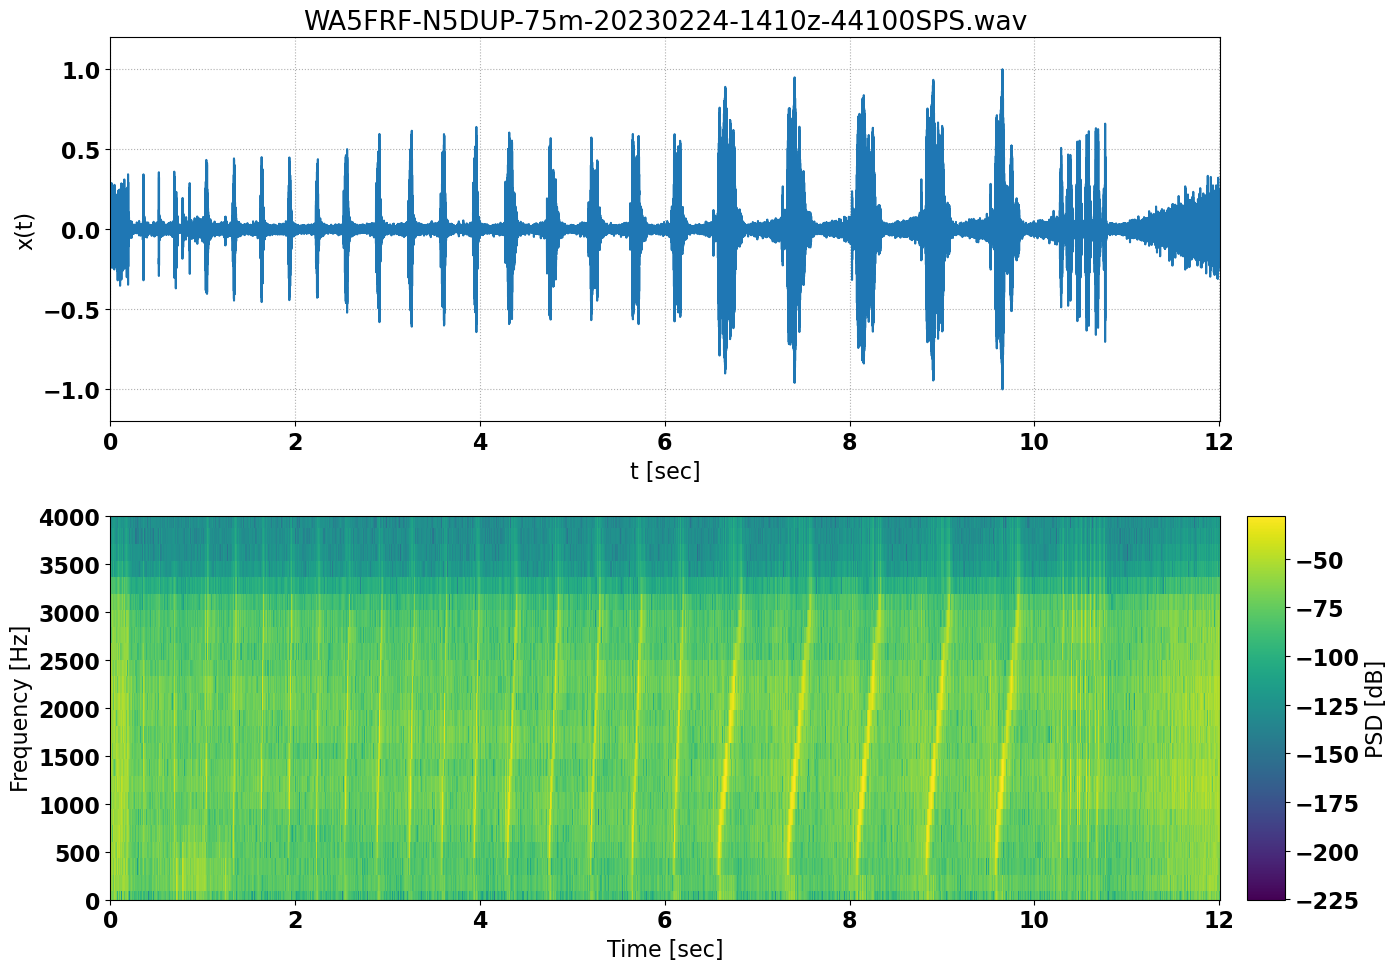

In [9]:
flim   = (0,4e3) # Set frequency limits for plotting purposes.
plot_sig(x0,title=fname,specgram=True,flim=flim)

In [10]:
# Play Wav File
play(x0)

## Select Time Period of Interest

In [11]:
tlim  = (7.3,7.6)

N: 529457 nperseg: 256 noverlap: 32


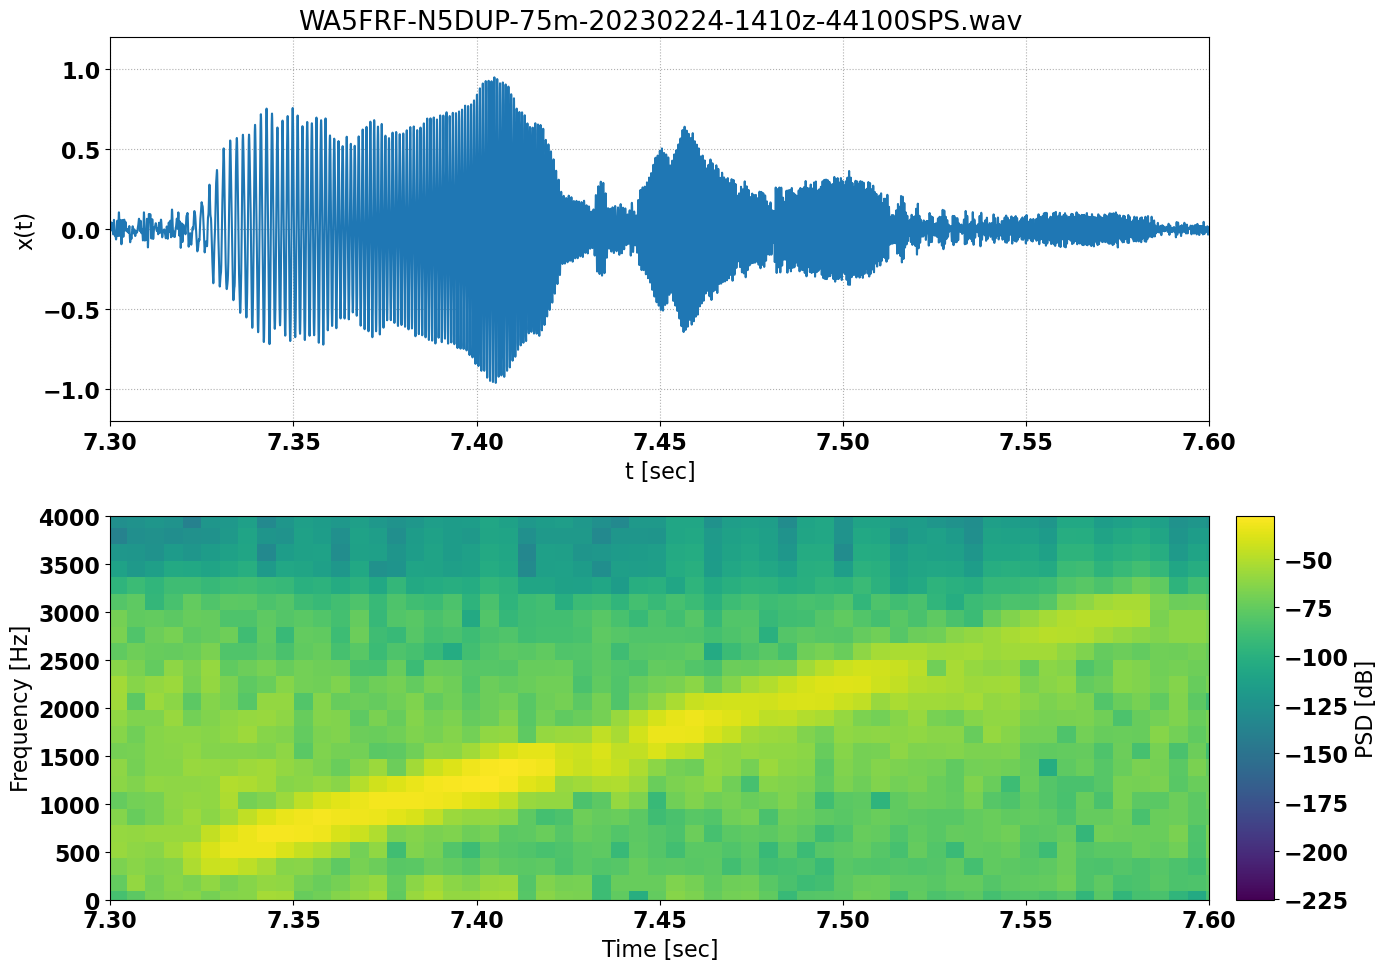

In [12]:
plot_sig(x0,title=fname,tlim=tlim,flim=flim,specgram=True)

In [13]:
13230/100.

132.3

In [14]:
play(x0,tlim=tlim)

## Squaring the Signal

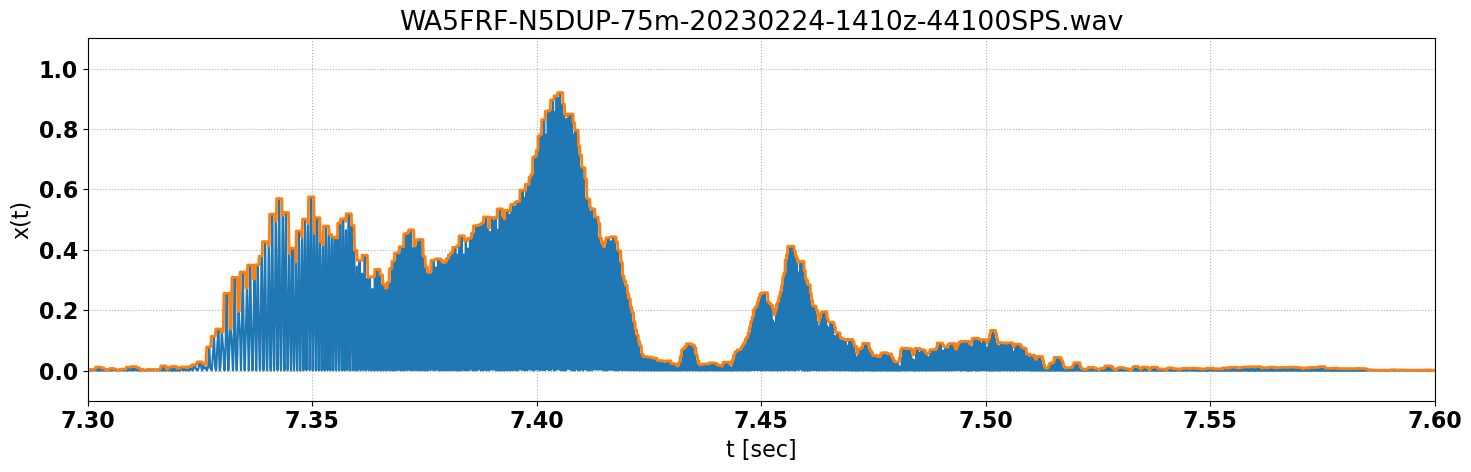

In [15]:
# Square the signal.
x1  = x0**2

# Compute envelope using a rolling max function.
Tc  = 1.2e-3 # Rolling Max Window [seconds]
env = x1.rolling(int(Tc*fs),center=True).max()
env = env.dropna() # Drop NaNs

# Plot result
plot_sig(x1,env,title=fname,tlim=tlim)

## Lowpass Filter

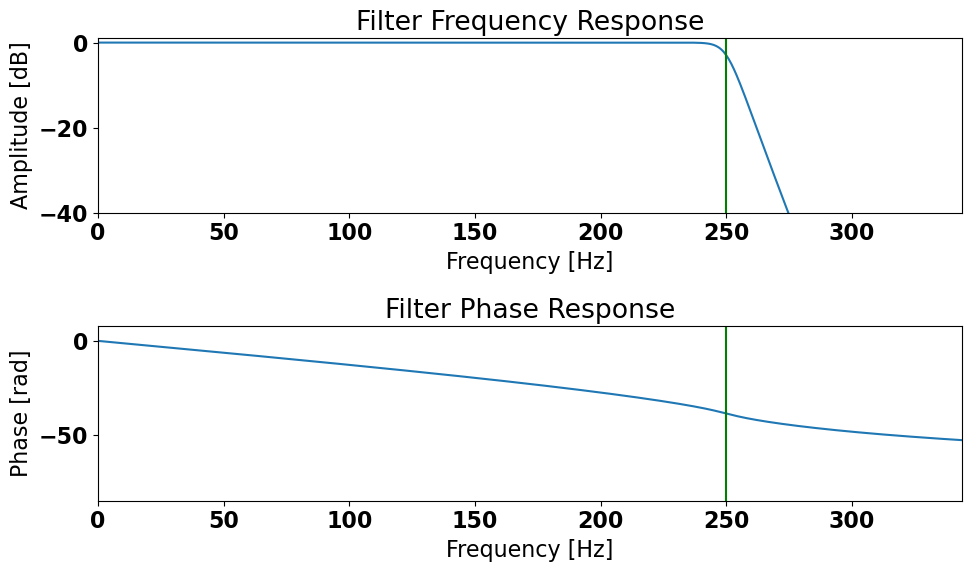

In [16]:
wp    = 250
ws    = 1.1*wp

gpass =  3 # The maximum loss in the passband (dB).
gstop = 40 # The minimum attenuation in the stopband (dB).

N, Wn = signal.buttord(wp, ws, gpass, gstop, fs=fs)
sos   = signal.butter(N, Wn, 'low', fs=fs, output='sos')

plot_filter_response(sos,fs,Wn,flim=(0,1.25*ws))

In [17]:
# Apply Filter to Signal
env_1      = env.copy()
env_1['x'] = signal.sosfiltfilt(sos,env['x'])

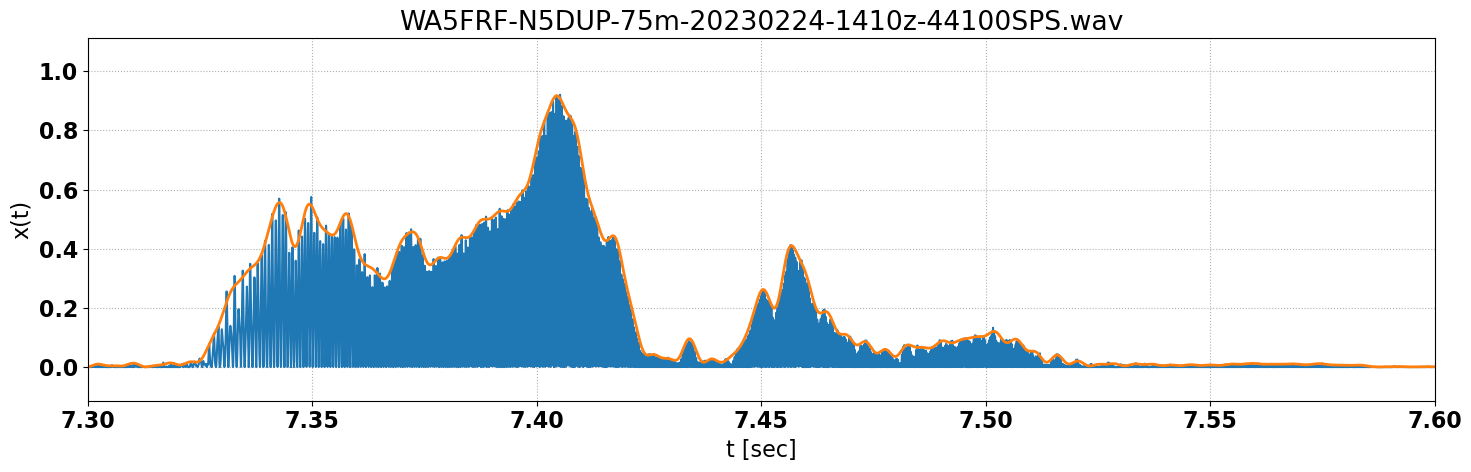

In [18]:
# Plot result
plot_sig(x1,env_1,title=fname,tlim=tlim)

## High Pass Filter

/tmp/ipykernel_66630/296678277.py:23: RuntimeWarning: divide by zero encountered in log10
  plt.plot(f, 20 * np.log10(abs(h)))


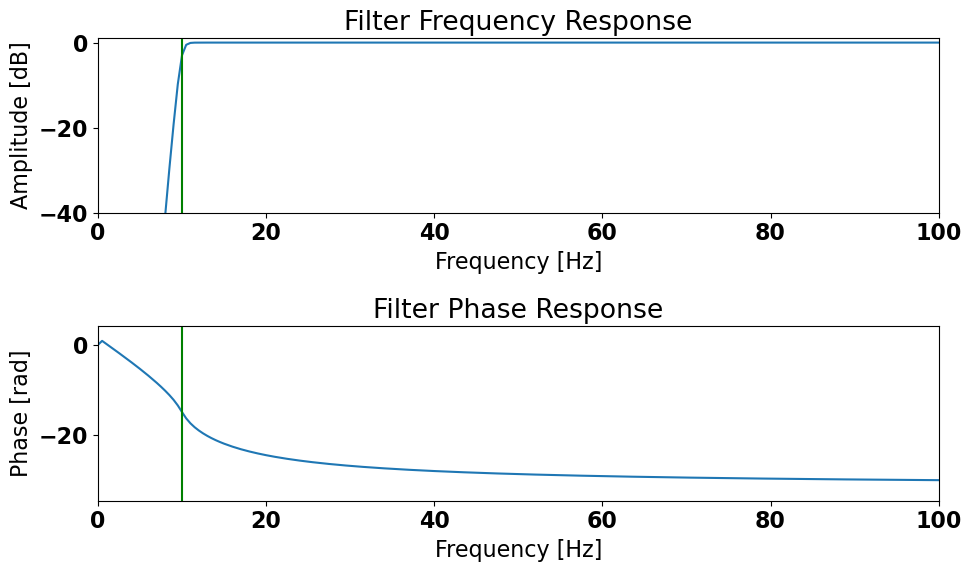

In [19]:
wp    = 10
ws    = 0.8*wp

gpass =  3 # The maximum loss in the passband (dB).
gstop = 40 # The minimum attenuation in the stopband (dB).

N, Wn = signal.buttord(wp, ws, gpass, gstop, fs=fs)
sos   = signal.butter(N, Wn, 'high', fs=fs, output='sos')

plot_filter_response(sos,fs,Wn,flim=(0,100))

In [20]:
# Apply Filter to Signal
env_2      = env_1.copy()
env_2['x'] = signal.sosfiltfilt(sos,env_1['x'])

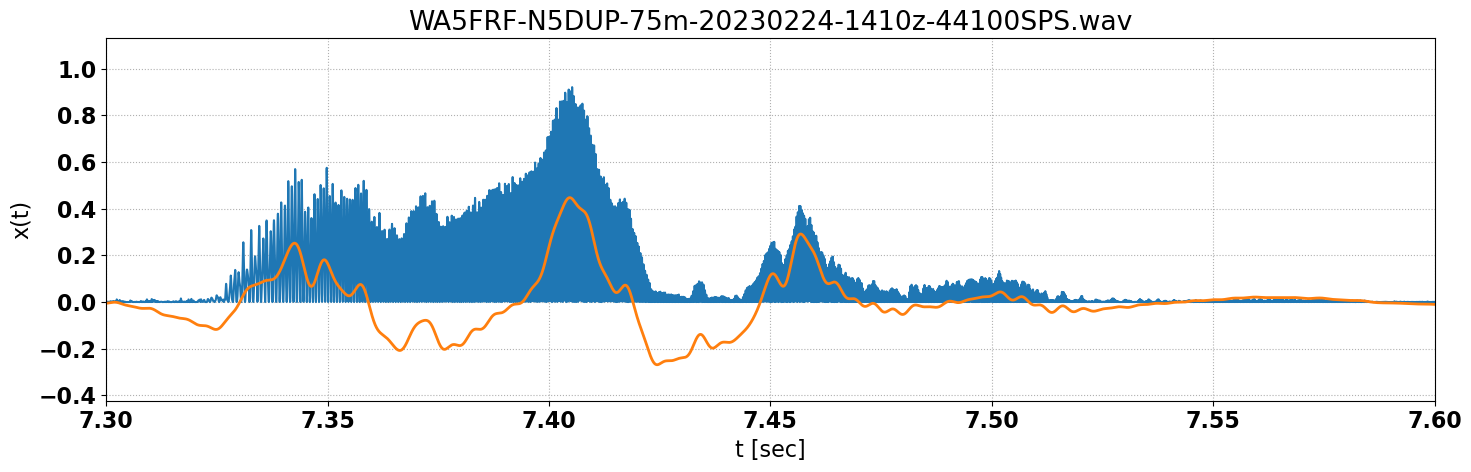

In [21]:
# Plot result
plot_sig(x1,env_2,title=fname,tlim=tlim)

# Calculate FFT

65536


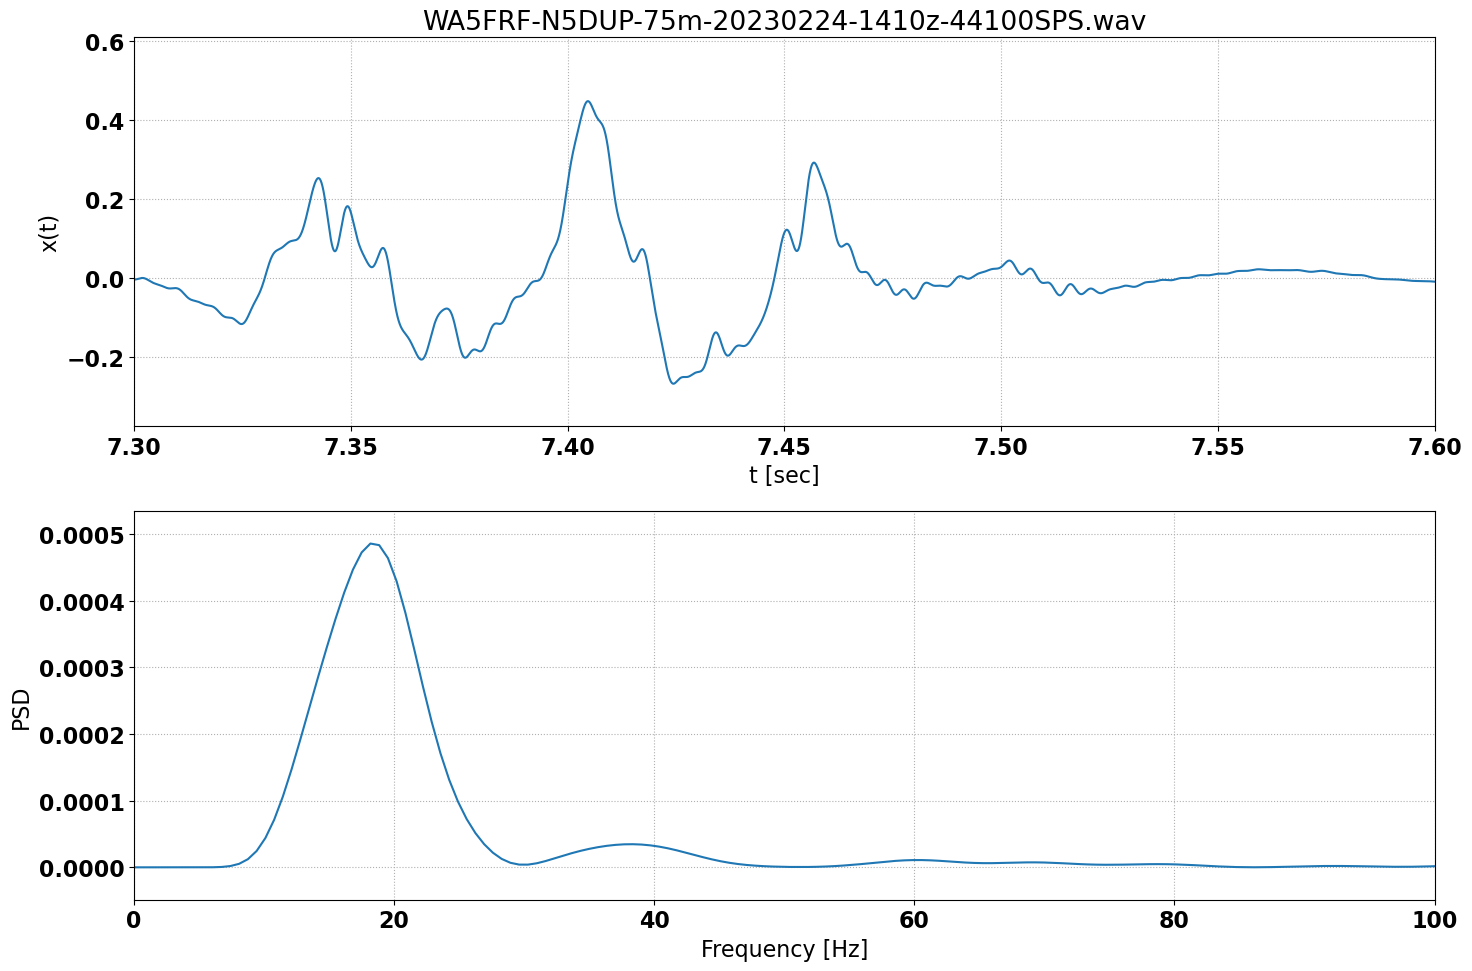

In [22]:
plot_sig(env_2,title=fname,tlim=tlim,fft=True,flim=(0,100))